# Problem Set: Solar Power Generation Data - examined by Andreas Eppler

# 1: Problem definition: short term solar power generation forecasting
Data taken from: https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_2_Weather_Sensor_Data.csv <br>
The data of the problem set has been gathered at two solar power plants located in India. The data covers a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at the plant level with a single array of sensors optimally placed at the plant.

There are a few areas of concern at the solar power plant -

1. Can we predict the power generation for next couple of days? - this allows for better grid management
2. Can we identify the need for panel cleaning/maintenance?
3. Can we identify faulty or suboptimally performing equipment?

I consider the first task to be the most important issue to investigate as in the coming years, the energy grid will be very dynamically regulated. Being able to forecast renewable energy production for the next couple of days will be a huge help to regulate the grid via storage solutions such as pumped-storage power plants and electric cars with bidirectional charging capability. This will allow to enable a stable, prosumer driven grid. <br>
The second and third tasks play an important role in ensuring the highest possible profitability of the solar power plant, which is important for the operating company. However, it plays a smaller role in the viability of the energy transition and will therefore not be investigated in the scope of this project

In [1230]:
from IPython.display import Image
Image(url="solar_power_plant.svg", width = 700)

time: 16 ms (started: 2022-03-06 23:10:02 +01:00)


#### 1.1 working principle of a solar power plant
The self-created image shows the basic build of a solar power plant. Rows of modules are wired together and then connected to an inverter, that transforms the DC current to an AC current in order to feed the energy into the electric grid. The single modules can either be wired together with a parallel or series connection (as shown in the above image). 
There are advantages and disadvantages to both the interconnection options.
- In a series connection, the current stays the same while the voltage is increased with each module. This allows for easy wiring. However, if only one of the modules is faulty or produces a lower current due to shading, the current and with that, the power of the whole installation decreases. 
- With a parallel connection, the voltage remeains persistent while the current of the modules is added up. With it, shading and faulty modules are less of a problem. However, faulty modules are also harder to detect. Due to the larger currents, the wiring requires more effort and is more expensive.

source: https://www.solaranlage.eu/photovoltaik/technik-komponenten/wechselrichter/konzepte-zur-verschaltung

#### 1.2 Choosing a measure of Loss/Success:

In [1231]:
#TODO Working hypothesis: chose a measure of loss / success: MSE, MAE, MAPE, R² score

time: 0 ns (started: 2022-03-06 23:10:03 +01:00)


#### 1.3 Customizing the evaluation protocol

In [1232]:
#TODO: How much Data spared for testing? How much for validation?

time: 0 ns (started: 2022-03-06 23:10:03 +01:00)


# 2: Data exploration and Preparation

In [1233]:
%pip install ipython-autotime
%load_ext autotime

Note: you may need to restart the kernel to use updated packages.
The autotime extension is already loaded. To reload it, use:Requirement already satisfied: pickleshare in c:\users\aeppl\appdata\roaming\python\python38\site-packages (from ipython->ipython-autotime) (0.7.5)
  %reload_ext autotime
time: 6.89 s (started: 2022-03-06 23:10:04 +01:00)


You should consider upgrading via the 'C:\Users\AEppl\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [1234]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import matplotlib.dates as mdates
hour_minutes = mdates.DateFormatter('%H:%M')
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 16 ms (started: 2022-03-06 23:10:11 +01:00)


In [1235]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 0 ns (started: 2022-03-06 23:10:12 +01:00)


In [1236]:
# ML Algorithms to be used

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 0 ns (started: 2022-03-06 23:10:12 +01:00)


## 2.1 Data Exploration

In the following, for the sake of improved clarity, only the second solar power plant is being investigated. However, provided underneath is the option to switch to the first power plant for reasons of boundless curiosity.

In [1237]:
# plant_no = 1
plant_no = 2

time: 0 ns (started: 2022-03-06 23:10:13 +01:00)


### 2.1.1 Plant Data:

In [1238]:
gen_data = pd.read_csv(f'Plant_{plant_no}_Generation_Data.csv')
gen_data

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,5/15/2020 0:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,5/15/2020 0:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,5/15/2020 0:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,5/15/2020 0:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,5/15/2020 0:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07
...,...,...,...,...,...,...,...
67693,6/17/2020 23:45,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05
67694,6/17/2020 23:45,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08
67695,6/17/2020 23:45,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06
67696,6/17/2020 23:45,4136001,xMbIugepa2P7lBB,0.0,0.0,4218.000000,1.068964e+08


time: 313 ms (started: 2022-03-06 23:10:13 +01:00)


There are seven columns for both the data sets consisting of the plant id (same for the entire dataset), the id of each inverter (source_key), AC- and DC-power, daily yield and total yield. From kaggle, we take the following information:
1. DATE_TIME:   Date and time for each observation. Observations recorded at 15 minute intervals.
2. PLANT_ID:    Plant ID - this will be common for the entire file. ***(can therefore be deleted)***
3. SOURCE_KEY:  Source key in this file stands for the inverter id.
4. DC_POWER:    Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. ***(explanation makes no sense, since power over a time interval would be energy, so it´s probably the average power during that interval. Also, it should be power generated by the modules connected to one inverter)***
5. AC_POWER:    Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. ***(should be average AC power after conversion by the inverter during each 15 minute interval)***
6. DAILY_YIELD: Daily yield is a cumulative sum of power generated on that day, till that point in time. ***(This is probably energy in kWh, not power, explanation for this assumption can be found later)***
7. TOTAL_YIELD: This is the total yield for the inverter till that point in time.

### 2.1.2 Weather Data:

In [1239]:
weather_data = pd.read_csv(f'Plant_{plant_no}_Weather_Sensor_Data.csv')
weather_data

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0
...,...,...,...,...,...,...
3254,2020-06-17 22:45:00,4136001,iq8k7ZNt4Mwm3w0,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,4136001,iq8k7ZNt4Mwm3w0,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,4136001,iq8k7ZNt4Mwm3w0,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,4136001,iq8k7ZNt4Mwm3w0,23.291048,22.373909,0.0


time: 94 ms (started: 2022-03-06 23:10:14 +01:00)


In [1240]:
weather_data["SOURCE_KEY"][0] in gen_data["SOURCE_KEY"]

False

time: 15 ms (started: 2022-03-06 23:10:14 +01:00)


--> weather sensor source key is not in list of inverter ids

We can see that the weather data covers the same period of time and is taken at the same plant (similar plant id). The data covers the ambient temperature, module temperature and the irradiation, which will be really helpful for time series prediction. 
Irradiation and with this the number of photons is directly linked to the energy output of the solar panels while the temperature of a solar module changes the efficiency of the modules. As a general rule, the efficiency of a solar panel declines with increasing temperatures. 
Unfortunately, as checked in the cell above, we don´t know which module the module temperature has been taken at but for the further analysis let´s assume that the temperature reading is representative for all the modules.
The temperature seems to be taken in degrees Celsius.
1. Date and time for each observation. Observations recorded at 15 minute intervals.
2. Plant ID - this will be common for the entire file. ***(can therefore be deleted)***
3. Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant. ***(can therefore be deleted)***
4. This is the ambient temperature at the plant. ***(most likely in °C)***
5. There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. ***(most likely in °C)***
6. Amount of irradiation for the 15 minute interval.

### 2.1.3 checking for missing data

In [1241]:
print(gen_data.info())
print(weather_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOTAL_YIELD  67698 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3259 non-null   object 
 1   PLANT_ID             3259 non-null   int64  
 2   SOURCE_KEY           3259 non-null   object 
 3   AMBIENT_TEMPERATURE  3259 non-null   float64
 4   MODULE_TEMPERATURE   3259 non-null  

Fortunately, the data seems to contain no null object values that need to be dealt with. However, a period of 34 days should cover 34x24x4= 3264 values, so there seem to be some missing time steps.

Let´s first convert the date and time information to represent the indices of our data frame.

In [1242]:
dt_gen, dt_weather = 0, 0
if plant_no == 1:
    dt_gen = pd.to_datetime(gen_data["DATE_TIME"], format='%d-%m-%Y %H:%M').values
    dt_weather = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S').values
if plant_no == 2:
    dt_gen = pd.to_datetime(gen_data["DATE_TIME"], format='%m/%d/%Y %H:%M').values
    dt_weather = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S').values
gen_data=(gen_data.set_index(pd.DatetimeIndex(dt_gen))).drop(['DATE_TIME', 'PLANT_ID'],axis=1)
weather_data=(weather_data.set_index(pd.DatetimeIndex(dt_weather))).drop(['DATE_TIME', 'PLANT_ID','SOURCE_KEY'],axis=1)

time: 93 ms (started: 2022-03-06 23:10:15 +01:00)


With this, we can now check for missing sonsor readings. To accomplish this, a list of all 15 minutes intervals between the first and last time step is created and compared with the datetime lists of the dataframe. The resulting number of inverter readings per time step is stored in a dictionary

In [1243]:
dt_list = np.arange(dt_gen[0], dt_gen[-1]+np.timedelta64(15, 'm'), np.timedelta64(15, 'm')).astype('datetime64[m]').tolist()  
dt_gen_dict = dict(zip(dt_list, [0]*len(dt_list)))
dt_weather_dict = dict(zip(dt_list, [0]*len(dt_list)))
counter = 0

for datetime in dt_list:
    while counter < len(dt_gen) and dt_gen[counter].astype('datetime64[m]') == datetime:
        dt_gen_dict[datetime] += 1
        counter += 1

counter=0
for datetime in dt_list:
    if dt_weather[counter].astype('datetime64[m]') == datetime:
        dt_weather_dict[datetime] += 1
        counter += 1

time: 2.08 s (started: 2022-03-06 23:10:16 +01:00)


In [1244]:
panel_lst = gen_data["SOURCE_KEY"].unique()
print(f"total number of inverters: {len(panel_lst)}")
# for p in panel_lst:
#     print(gen_data.loc[gen_data["SOURCE_KEY"] == p].shape[0], end = " ")

total number of inverters: 22
time: 16 ms (started: 2022-03-06 23:10:18 +01:00)


As found out above, the total number of inverters is 22. Now let´s find all the time slots where the number of inverter readings stored in the data differs from the total number of inverters:

In [1245]:
tmp = dt_list[0]
for p in dt_list:
    if dt_gen_dict[tmp] != dt_gen_dict[p]:
        if dt_gen_dict[tmp] != len(panel_lst):
            print(f"from {tmp} to {p}, delta = {p-tmp} {dt_gen_dict[tmp]} inverter readings")
        tmp = p
correction_list = [s for s in dt_gen_dict if dt_gen_dict[s]!=22 and dt_gen_dict[s]!=0]

from 2020-05-15 23:15:00 to 2020-05-15 23:30:00, delta = 0:15:00 0 inverter readings
from 2020-05-19 16:00:00 to 2020-05-19 16:15:00, delta = 0:15:00 0 inverter readings
from 2020-05-19 22:15:00 to 2020-05-20 14:15:00, delta = 16:00:00 12 inverter readings
from 2020-05-20 22:00:00 to 2020-05-29 16:00:00, delta = 8 days, 18:00:00 18 inverter readings
from 2020-05-29 16:00:00 to 2020-05-29 16:15:00, delta = 0:15:00 0 inverter readings
from 2020-06-01 17:45:00 to 2020-06-01 18:00:00, delta = 0:15:00 0 inverter readings
from 2020-06-03 14:00:00 to 2020-06-03 14:15:00, delta = 0:15:00 0 inverter readings
time: 0 ns (started: 2022-03-06 23:10:19 +01:00)


This does not look too bad. There are only five occurances where all inverter sensor readings failed at once, whilst only for one 15 minute time step. This will be of no concern for the later investigation. What is even better, as can be seen below, the missing inverter sensor reading times are similar to the missing weather sensor reading times. The two time windows of concern however, are the ones with only 12 / 18 inverter readings, as those would later lead to erroneous training data, if left uncorrected. It is unclear if the data is missing due to malfunctioning sensors or because the solar module did not work during that period of time.

In [1246]:
tmp = dt_list[0]
for p in dt_list:

    if dt_weather_dict[tmp] != dt_weather_dict[p]:
        if dt_weather_dict[tmp] == 0:
            print(f"from {tmp} to {p}, delta = {p-tmp} no sensor data available")
        tmp = p

from 2020-05-15 23:15:00 to 2020-05-15 23:30:00, delta = 0:15:00 no sensor data available
from 2020-05-19 16:00:00 to 2020-05-19 16:15:00, delta = 0:15:00 no sensor data available
from 2020-05-29 16:00:00 to 2020-05-29 16:15:00, delta = 0:15:00 no sensor data available
from 2020-06-01 17:45:00 to 2020-06-01 18:00:00, delta = 0:15:00 no sensor data available
from 2020-06-03 14:00:00 to 2020-06-03 14:15:00, delta = 0:15:00 no sensor data available
time: 0 ns (started: 2022-03-06 23:10:19 +01:00)


### 2.1.4 plotting the data:

For the correction, we will now find out wether the missing inverter data is also influencing the daily, as well as the total yield. For this purpose, let´s plot them:

<AxesSubplot:>

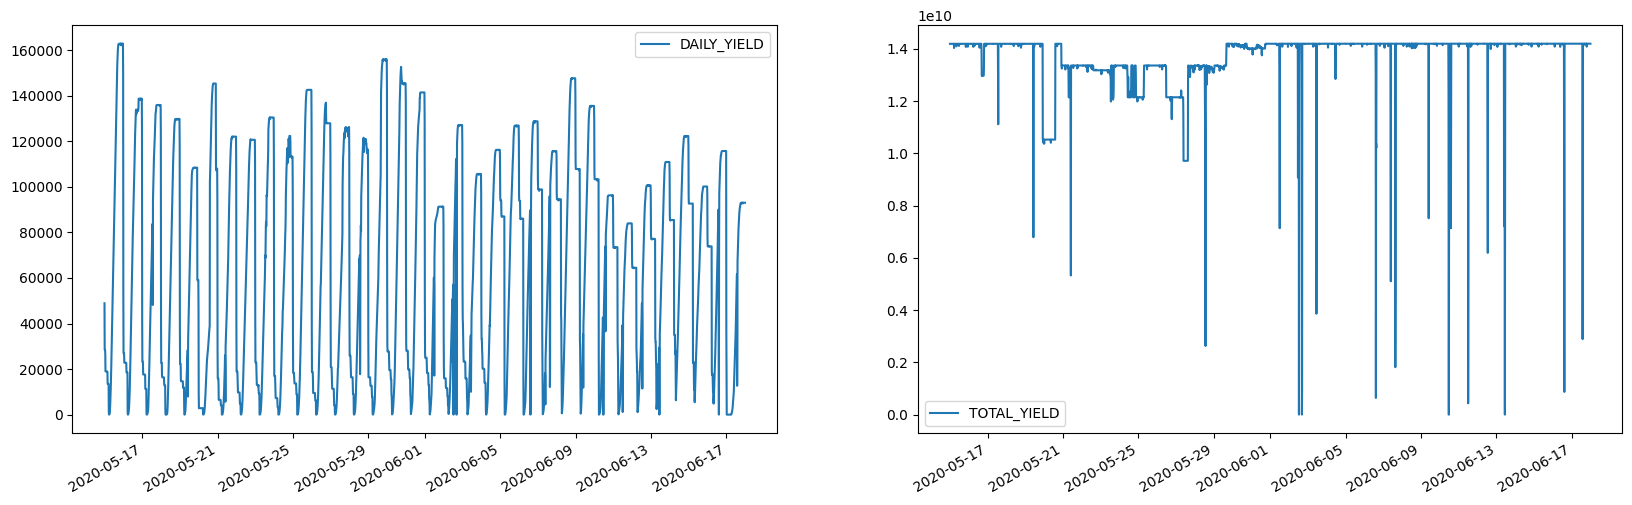

time: 1.16 s (started: 2022-03-06 23:10:20 +01:00)


In [1247]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
gen_data_inv_sum = gen_data.groupby(gen_data.index).sum()
gen_data_inv_sum.plot(y = 'DAILY_YIELD', ax = ax[0])
gen_data_inv_sum.plot(y = 'TOTAL_YIELD', ax = ax[1]) 

Looking at the plots, we can see that there seem to exist a lot of erroneous data points, both for the daily yield as well as the total yield. The daily yield should as per definition be zero at 0:00, increase over each day according to each day´s AC-power production and then drop straight to zero again at 0:00. This is not at all what the plot describes for most days. The total yield looks also really bad. According to its definition, it should only ever increase, which it clearly does not. If we switch to plant 1, we see that the plots look a lot more as expected, but still contain a lot of errors. <br>
Let´s check, wether all the data is as erroneous. Following, you can find plots of the other parameters, plotted as point plots over a single day:

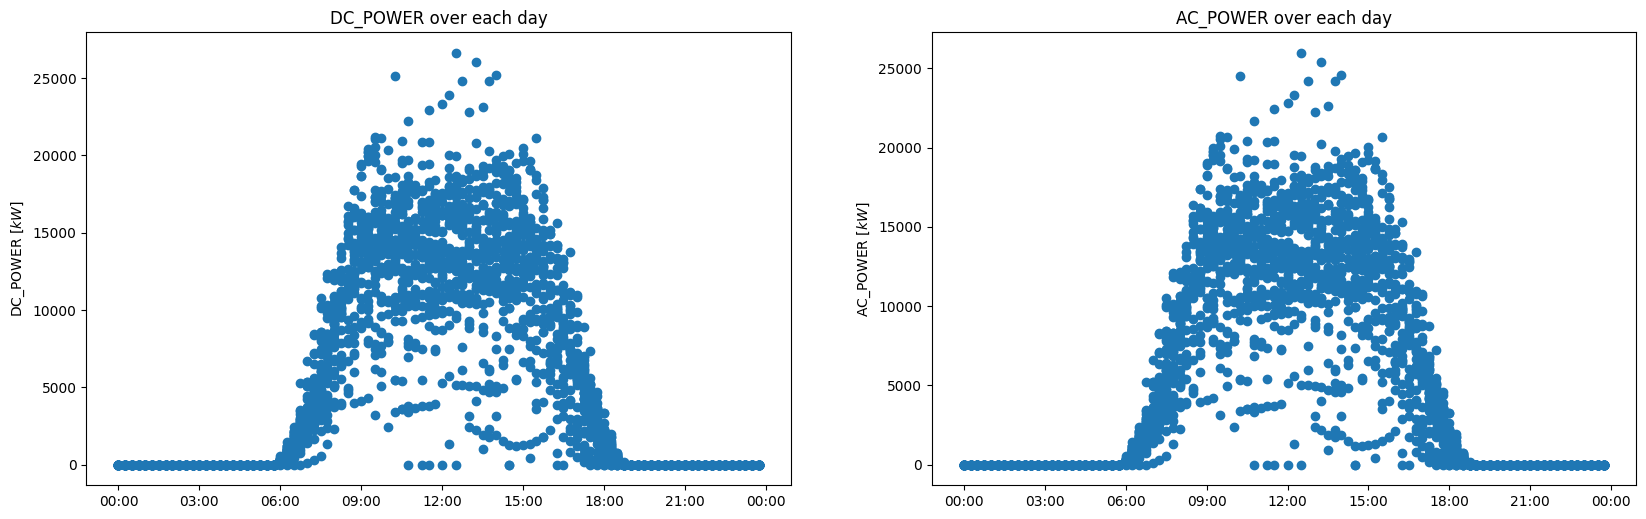

time: 1.33 s (started: 2022-03-06 23:10:21 +01:00)


In [1248]:
def plot_ac_dc_power(df):
    fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
    for i, name in enumerate(['DC_POWER', 'AC_POWER']):
        ax[i].scatter([dt.datetime.combine(dt.date(2020,1,1), t) for t in df.index.time], df[name])
        ax[i].set_ylabel(f'{name} $[kW]$')
        ax[i].set_title(f"{name} over each day")
        ax[i].xaxis.set_major_formatter(hour_minutes)

plot_ac_dc_power(gen_data_inv_sum)

Luckily, this looks a lot better that the daily and total yield. This are the key take-aways:
- First, we see that the plots look very similar except for a small scaling factor (efficiency of the inverter). As we will see later on in the correlation plot, the relationship is in fact linear. Side note: for plant 1, the AC power is around 10.3 times smaller than the DC power, so the efficiency would be around 9.7%, which would be really bad. There seems to be a scaling error of one decimal point for the DC power, since all the other data (daily yield, total yield, ac power) is consistent. 
- It makes sense that during nighttime hours (around 18:00 till 6:00) there is no power production.
- The power production seems to rise to a certain amount in the morning, then stays pretty consistent over the day and falls in the evening (looking a little like a capped gaussian distribution)
- There are some data points where the power production is zero over the day even though the irradiation isn´t (as can be seen below). These data points are only over one 15 minute interval so it seems unlikely, that this is due to repairs / other. Probably, these are errors in the data that need to be fixed.

In [1370]:
#efficiency of the inverter:
np.mean(gen_data_inv_sum['AC_POWER']/gen_data_inv_sum['DC_POWER'])

0.9766894265937723

time: 47 ms (started: 2022-03-07 19:05:47 +01:00)


According to https://understandsolar.com/solar-inverter-efficiency/, this is actually top notch. Alos, the inverters are probably from SMA Solar or SolarEdge.

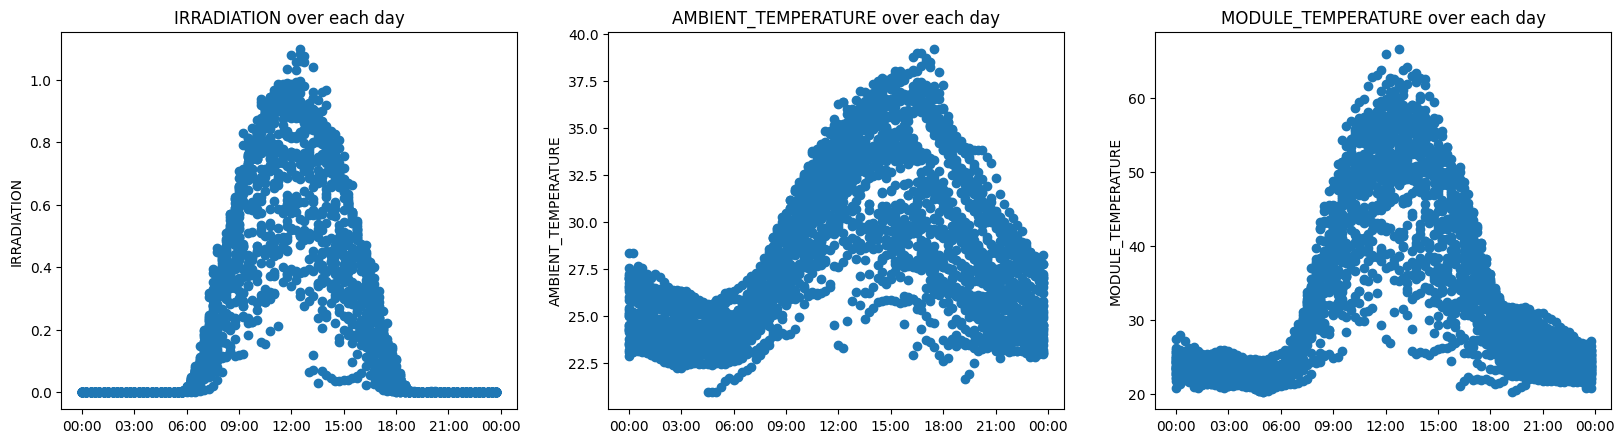

time: 1.62 s (started: 2022-03-06 23:10:23 +01:00)


In [1249]:
fig,ax = plt.subplots(ncols=3,nrows=1, dpi=100,figsize=(20,5))
for i, name in enumerate(['IRRADIATION','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE']):
    ax[i].scatter([dt.datetime.combine(dt.date(2020,1,1), t) for t in weather_data.index.time], weather_data[name])
    ax[i].set_ylabel(f'{name}')
    ax[i].xaxis.set_major_formatter(hour_minutes)
    ax[i].set_title(f"{name} over each day")

Take-aways:
- The weather sensor data looks really clean and consistent. We can see that the irradiation closely matches the power curves without being capped off, while the module temperature is a overlay of the irradiation and the ambient temperature. All this seems to confirm our physical understanding.
- If we tried to match the irradiation data to the sunrise and sunset data of that particular month and the ambient temperature to the climatic conditions, we could probably narrow down where the plant is stationed in india.
- This place gets really hot in summer

## 2.3 Data Preparation

Now we gained all the insights we need to start correcting the erroneous data. The revealed issues will be dealt with as follows:
1. step: The $total\ yield$ will be deleted as it currently has no identifiable surplus value and can easily be reconstructed from the AC power column which will be way easyer than correcting this mess.
2. step: We will try to use linear regression to correct all the zero power production values during daytime hours
3. step: There are several possible methods to deal with the missing inverter data.
- neglecting the parts of the data set where inverters are missing - waste of a lot of useful data
- interpolation of data for the missing inverters - not feasible since the time spans are by far too large
- summing up the power generation of all the inverters per time step while creating another column with the number of working inverters which would have the benefit that the model would take into account the possibility of inverters being out of service, however with only two occurances, the training data would be to limited to understand this relationship
- which leads us to the most feasible solution: summing up the power generation of all the inverters per time step and scaling the power production with the total  number of inverters, divided by the functioning inverters. Of course, we cannot assume that all the inverters produce an equal amount of power but the margin of error should be little enough.
4. step: We will create a correct list of the daily yield and replace the column in the data frame from the AC power column

### 2.3.1 Dropping the total yield

In [1250]:
gen_data = gen_data.drop(['TOTAL_YIELD'], axis = 1)
gen_data_inv_sum = gen_data_inv_sum.drop(['TOTAL_YIELD'], axis = 1)

time: 16 ms (started: 2022-03-06 23:10:26 +01:00)


### 2.3.2 correcting all zero power production values: 

In [1251]:
sunrise = 8
sunset = 17
date_time = pd.DatetimeIndex(gen_data_inv_sum.index.values)
day_ix = (date_time.hour >= sunrise) & (date_time.hour <= sunset)
daytime_zeros = day_ix & (gen_data_inv_sum['AC_POWER'] == 0)
gen_data_inv_sum[daytime_zeros]
for i in range(len(daytime_zeros)):
    if daytime_zeros[i]:
        gen_data_inv_sum.iloc[i,0:2] = None
print(f'number of null objects before interpolation: {gen_data_inv_sum.isnull().sum().sum()}')
gen_data_inv_sum = gen_data_inv_sum.interpolate(limit = 1, method ='linear', limit_direction ='both')
print(f'number of null objects after interpolation: {gen_data_inv_sum.isnull().sum().sum()}')

number of null objects before interpolation: 22
number of null objects after interpolation: 0
time: 62 ms (started: 2022-03-06 23:10:26 +01:00)


We can see that 22 daytime zero values were found and corrected via interpolation. The resulting plot can be seen below.

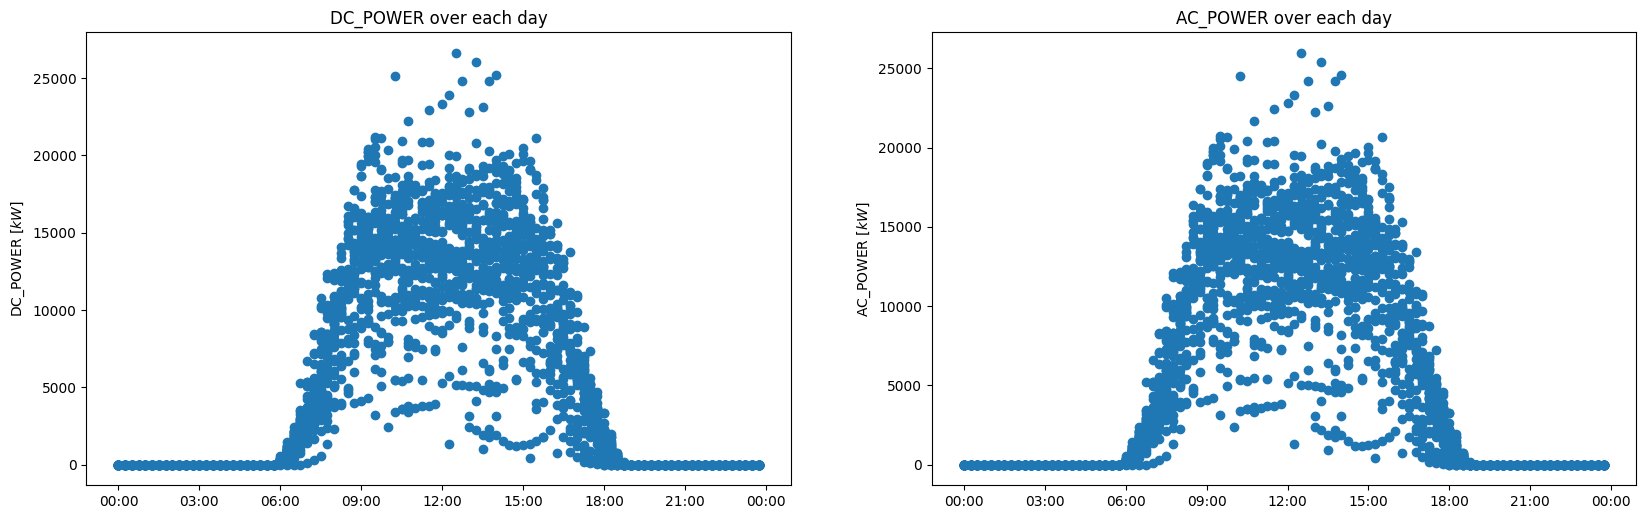

time: 953 ms (started: 2022-03-06 23:10:27 +01:00)


In [1252]:
plot_ac_dc_power(gen_data_inv_sum)

### 2.3.3 missing inverter data correction

since we know that the irradiation and the AC power are closely linked, let´s use this to check wether our correction makes sense

In [1253]:
def plot_daily_yield_and_irradiation(dataframe):
    df_sum_over_dates = dataframe.groupby(dataframe.index.date).sum()
    fig,ax = plt.subplots(dpi=100,figsize=(10,6))

    plt.ioff()
    plt.grid()
    fig.autofmt_xdate()
    ax.plot(df_sum_over_dates['IRRADIATION'], label="irradiation", color="b")
    ax.set_ylabel("irradiation",color="b")
    ax2=ax.twinx()
    ax2.plot(df_sum_over_dates['AC_POWER'], color="g")
    for x, date in enumerate(list(set([d.date() for d in correction_list]))):
        if x!= 0:
            if x==1:
                ax2.plot(df_sum_over_dates['AC_POWER'][tmp:date], label="missing inverter data corrected", color="r")
            else:
                ax2.plot(df_sum_over_dates['AC_POWER'][tmp:date], color="r")
        tmp = date
    ax2.set_ylabel(f'AC power $[kW]$', color="g")
    ax2.legend(loc='upper right', shadow=False, fancybox=False, facecolor='white', edgecolor='black')
    ax2.set_title("AC power and irradiation")

time: 0 ns (started: 2022-03-06 23:10:28 +01:00)


This is how the plots look prior to the correction. As predicted, we notice a close correlation for all but the tim span with the missing inverter data.

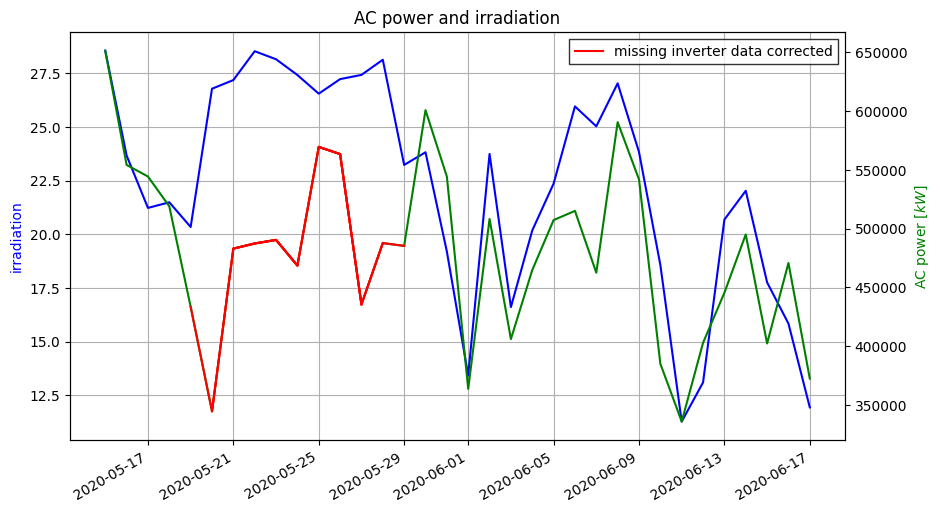

time: 891 ms (started: 2022-03-06 23:10:28 +01:00)


In [1254]:
plot_daily_yield_and_irradiation(pd.merge(gen_data.groupby(gen_data.index).sum(), weather_data, left_index=True, right_index=True))

In [1255]:
tmp = pd.DataFrame(list(dt_gen_dict.items()), columns = ['DATE_TIME','NO_INVERTERS'])
tmp = (tmp.set_index(pd.DatetimeIndex(pd.to_datetime(tmp["DATE_TIME"]).values))).drop(['DATE_TIME'],axis=1)
corrected_df = pd.merge(gen_data_inv_sum, tmp, left_index=True, right_index=True)
print(corrected_df.loc[correction_list[0]])
for datetime in correction_list:
    corrected_df.loc[datetime] = corrected_df.loc[datetime]/dt_gen_dict[datetime]*22
print(corrected_df.loc[correction_list[0]])


DC_POWER            0.0
AC_POWER            0.0
DAILY_YIELD     59143.0
NO_INVERTERS       12.0
Name: 2020-05-19 22:15:00, dtype: float64
DC_POWER             0.000000
AC_POWER             0.000000
DAILY_YIELD     108428.833333
NO_INVERTERS        22.000000
Name: 2020-05-19 22:15:00, dtype: float64
time: 969 ms (started: 2022-03-06 23:10:30 +01:00)


From the above example and the plot below, we can see that the correction was successfull and as expected. The correction probably is not perfect but the correlation definitely looks better.

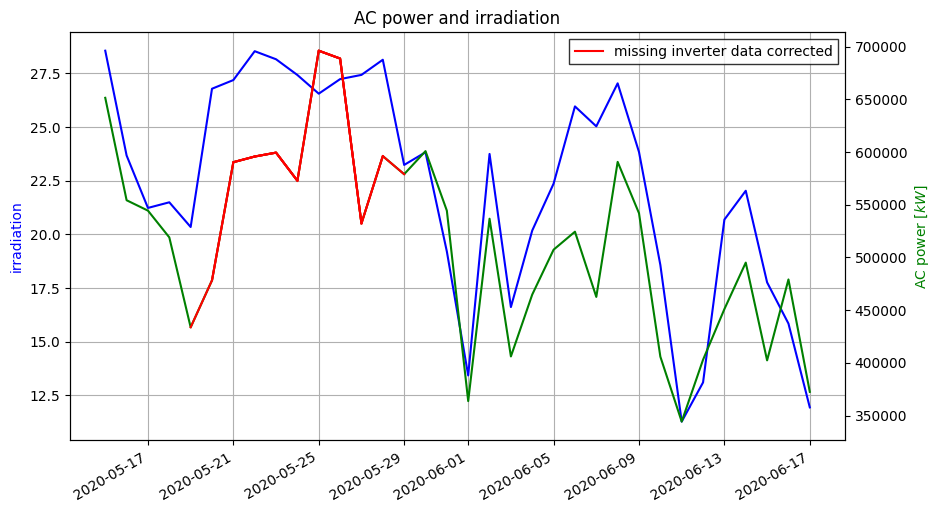

time: 781 ms (started: 2022-03-06 23:10:31 +01:00)


In [1256]:
plot_daily_yield_and_irradiation(pd.merge(corrected_df, weather_data, left_index=True, right_index=True).drop('NO_INVERTERS', axis = 1))


### 2.3.4: let´s now create a function that enables us to create a corrected list of the daily yield

In [1296]:
def create_daily_yield_list(dataframe, ac_power):
    day_list = []
    for i in list(pd.date_range(start=dataframe.index[0], end=dataframe.index[-1], freq='D')):
        day_list.append(i.strftime('%Y-%m-%d'))
    daily_yield = []
    for datetime in day_list:
        tmp = 0
        for idx, row in dataframe[datetime].iterrows():
            tmp += row[ac_power]
            daily_yield.append(tmp)
    return daily_yield
corrected_df['DAILY_YIELD'] = create_daily_yield_list(gen_data_inv_sum, 'AC_POWER')
df_plant = pd.merge(corrected_df, weather_data, left_index=True, right_index=True).drop('NO_INVERTERS', axis = 1)
df_plant

,DC_POWER,AC_POWER,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
2020-05-15 00:00:00,0.0,0.0,0.000000,27.004764,25.060789,0.0
2020-05-15 00:15:00,0.0,0.0,0.000000,26.880811,24.421869,0.0
2020-05-15 00:30:00,0.0,0.0,0.000000,26.682055,24.427290,0.0
2020-05-15 00:45:00,0.0,0.0,0.000000,26.500589,24.420678,0.0
2020-05-15 01:00:00,0.0,0.0,0.000000,26.596148,25.088210,0.0
...,...,...,...,...,...,...
2020-06-17 22:45:00,0.0,0.0,372436.317143,23.511703,22.856201,0.0
2020-06-17 23:00:00,0.0,0.0,372436.317143,23.482282,22.744190,0.0
2020-06-17 23:15:00,0.0,0.0,372436.317143,23.354743,22.492245,0.0
2020-06-17 23:30:00,0.0,0.0,372436.317143,23.291048,22.373909,0.0


time: 750 ms (started: 2022-03-07 11:06:49 +01:00)


We see that the plot resembles the other plot closely with the errors being correctet. The new plot is scaled by a factor of 4. I can only guess how this factor comes into play. Most likely, the daily yield is in kWh, so the daily yield would be an integral of the power over the day. Since every quaterly average AC power has to be multiplied by $1/4 hr$ to achieve this, the factor would make sense.

<AxesSubplot:>

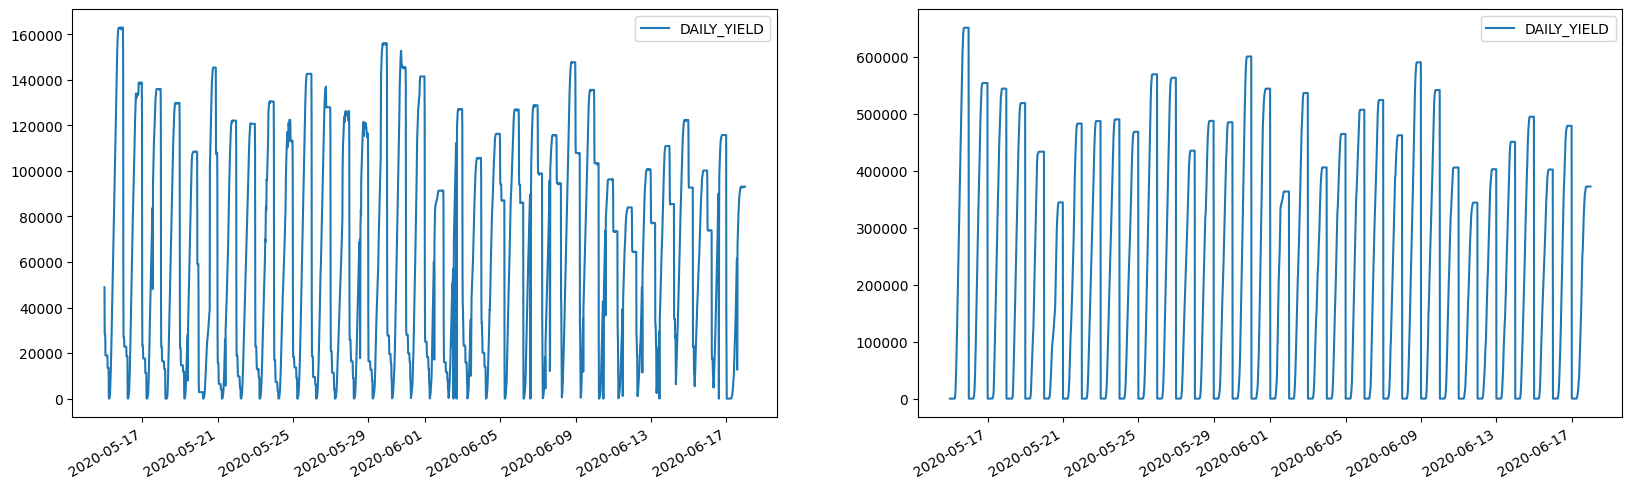

time: 906 ms (started: 2022-03-07 11:06:57 +01:00)


In [1297]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
fig.autofmt_xdate()
gen_data_inv_sum.plot(y = 'DAILY_YIELD', ax = ax[0])
df_plant.plot(y = 'DAILY_YIELD', ax = ax[1])

Let´s corect this factor:

In [1368]:
df_plant['DAILY_YIELD'] = df_plant['DAILY_YIELD'].apply(lambda x: x/4)
df_plant['DAILY_YIELD'].max()

162859.43416700777

time: 0 ns (started: 2022-03-07 18:44:46 +01:00)


## 2.4 Correlations

In [1259]:
correlationMatrix2 = pd.DataFrame(df_plant).corr() 
correlationMatrix2.style.background_gradient(cmap='viridis').set_precision(2)

,DC_POWER,AC_POWER,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DC_POWER,1.00,1.00,0.06,0.67,0.90,0.93
AC_POWER,1.00,1.00,0.06,0.67,0.90,0.93
DAILY_YIELD,0.06,0.06,1.00,0.52,0.22,0.03
AMBIENT_TEMPERATURE,0.67,0.67,0.52,1.00,0.85,0.67
MODULE_TEMPERATURE,0.90,0.90,0.22,0.85,1.00,0.95
IRRADIATION,0.93,0.93,0.03,0.67,0.95,1.00


time: 109 ms (started: 2022-03-06 23:10:34 +01:00)


There´s a lot of insight to be gained here. 
- DC and AC power are perfectly correlated --> there is a linear relationship of the inverter input to output power with its slope being the efficiency of the inverter. 
- irradiation, ac power, dc power, module temperature and ambient temperature are all correlated closely which makes absolute sense. Broken down, the irradiation directly influences the dc power (minus shadowing and efficiency) and the ambient temperature, while the module temperature is influenced by the ambient temperature and the waste energy of the panels and itself infulences the efficiency
- the daily yield shows correlation with the temperature, not so much with the other values. This makes sense, since looking at the pairplots below, we can see a quadratic relationship.
> This is very valuable information. Our aim is to predict the power generated by the solar plant, so we could either predict the DC power, AC power or the daily yield. We now know that the DC power is the AC power multiplied by the efficiency of the inverter, which we also know. What is more, we can construct the daily yield from the ac power and vice versa. <br> So we are theoretically free of choice in what quantity we want to predict. However, if we use the weather data, it allows for smaller models if the underlying relationships are linear instead of quadratic. In those cases, it will be advantageous to predict the ac power in order to save ressources

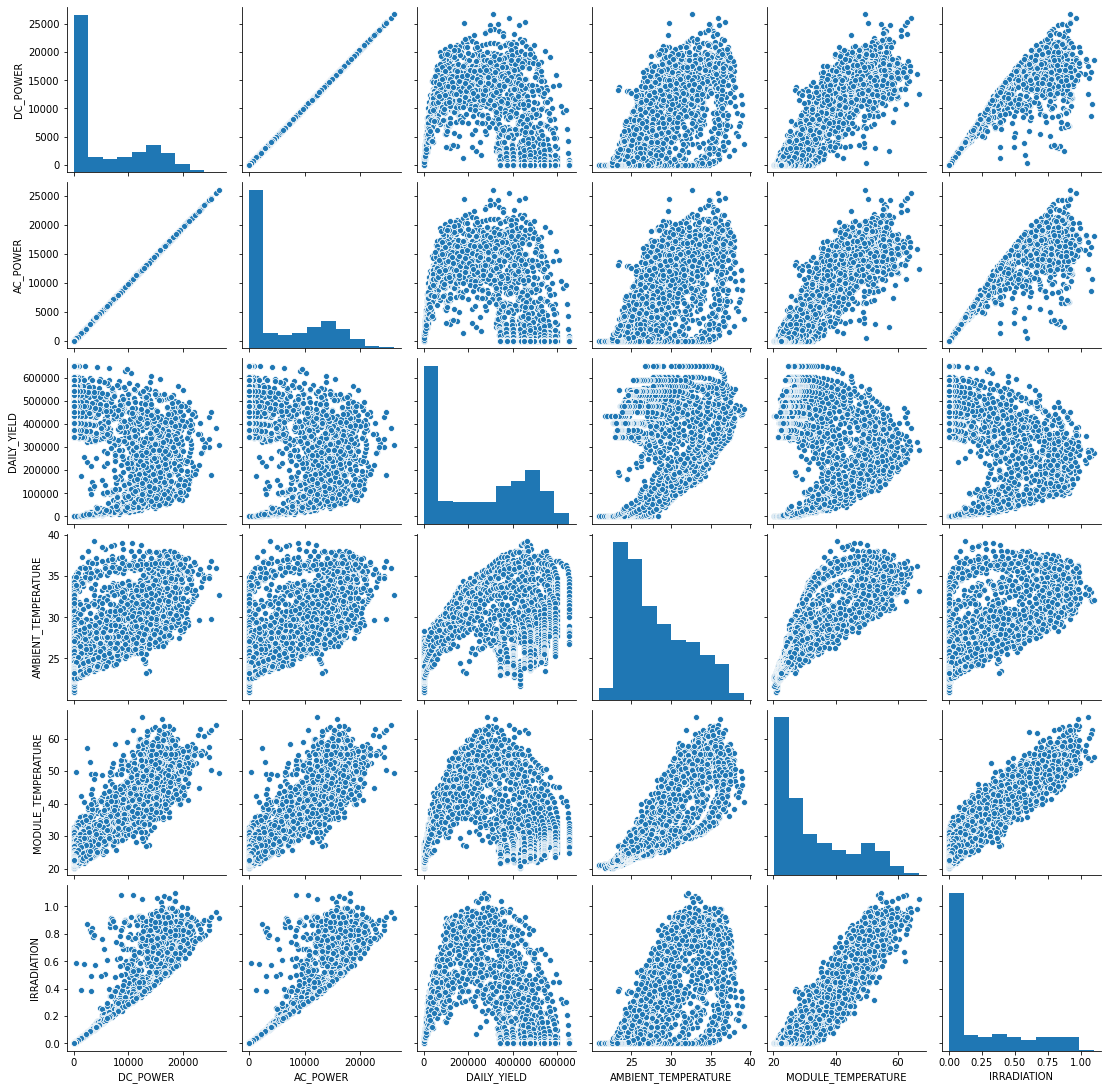

time: 9.48 s (started: 2022-03-06 23:10:34 +01:00)


In [1260]:
sns.pairplot(df_plant)
plt.show()

### 2.4.1 Seasonal Decomposition

Seasonal decomposition is unfortunately not possible due to the short time period of only 34 days

### 2.4.2 lag plot

Since we will not use the weather data in order to predict using the SARIMAX function, we will have to compare the plots for both the daily yield and the ac power to decide which one is better suited.

<Figure size 576x576 with 0 Axes>

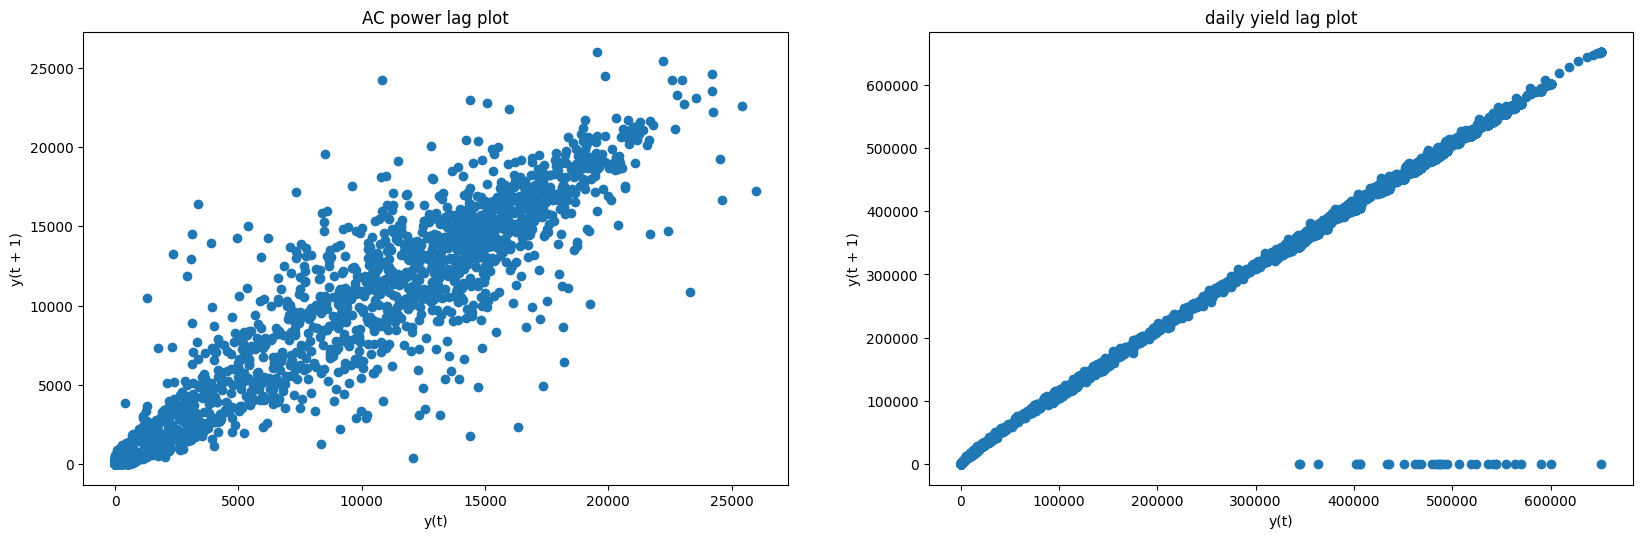

time: 750 ms (started: 2022-03-06 23:10:44 +01:00)


In [1261]:
# Plotting the figure:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
lag_plot(df_plant['AC_POWER'], ax = ax[0], lag=1)
lag_plot(df_plant['DAILY_YIELD'], ax = ax[1], lag=1)
ax[0].set_title('AC power lag plot')
ax[1].set_title('daily yield lag plot');

We can see that both plots show a clear relationship between two following timesteps with seemingly randomly distributed outliers for the AC power plot. The daily yield lag plot shows a very distinct relationship with outliers on the $y(t)$ axis. The first observation for the daily yield make sense since because of the incremental addition operation, $y(t+1)$ and $y(t)$ are quite similar. The outliers can be explained by the fact that each day at 0:00, the daily_yield is set to zero again.

### 2.4.3 autocorrelation plot

Text(0.5, 1.0, 'AC power autocorrelation plot')

<Figure size 576x576 with 0 Axes>

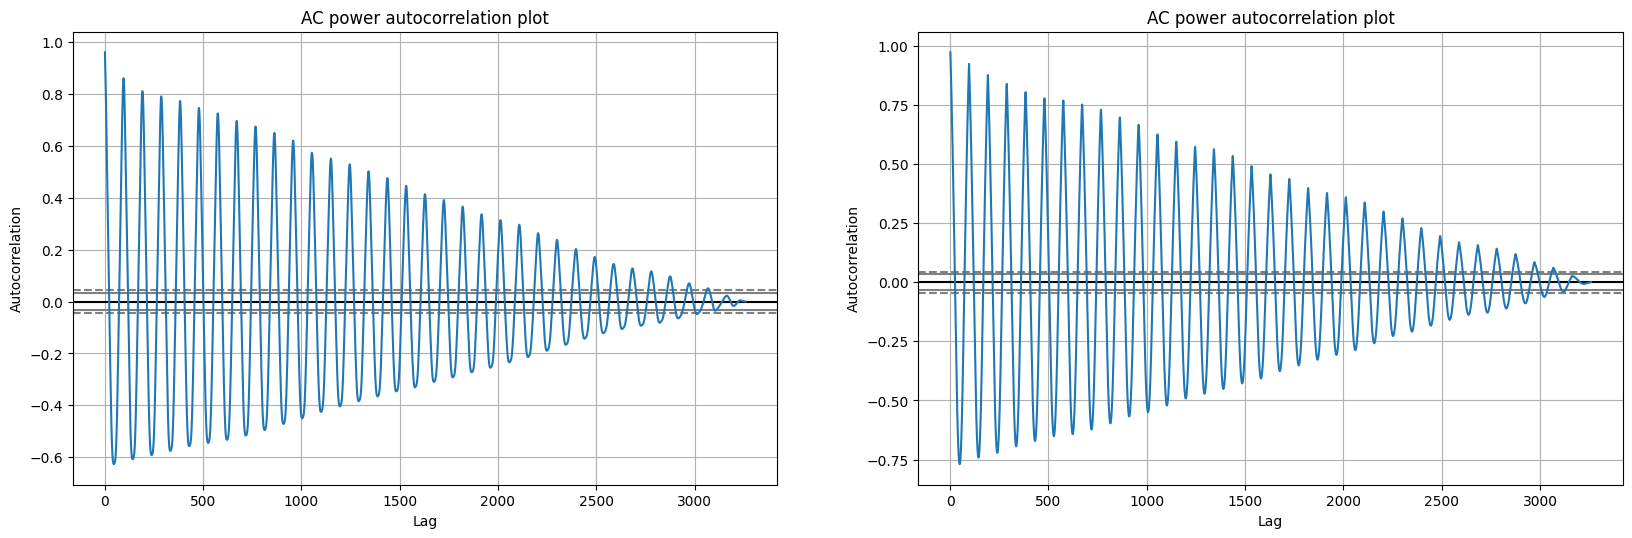

time: 937 ms (started: 2022-03-07 19:29:09 +01:00)


In [1372]:
plt.figure()
fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
autocorrelation_plot(df_plant['AC_POWER'], ax = ax[0])
autocorrelation_plot(df_plant['DAILY_YIELD'], ax = ax[1])
ax[0].set_title(f'AC power autocorrelation plot')
ax[1].set_title(f'AC power autocorrelation plot')

We can see that there is correlation for a lot of the the previous time steps. Interestingly, both the plots look very similar, but since the daily yield is created from the AC power by summating over it, there inevitably is correlation.

For the sake of readability and since the plots look very similar, we will now only plot the daily yield for the following zoomed-in autocorrelation plots.

<Figure size 576x576 with 0 Axes>

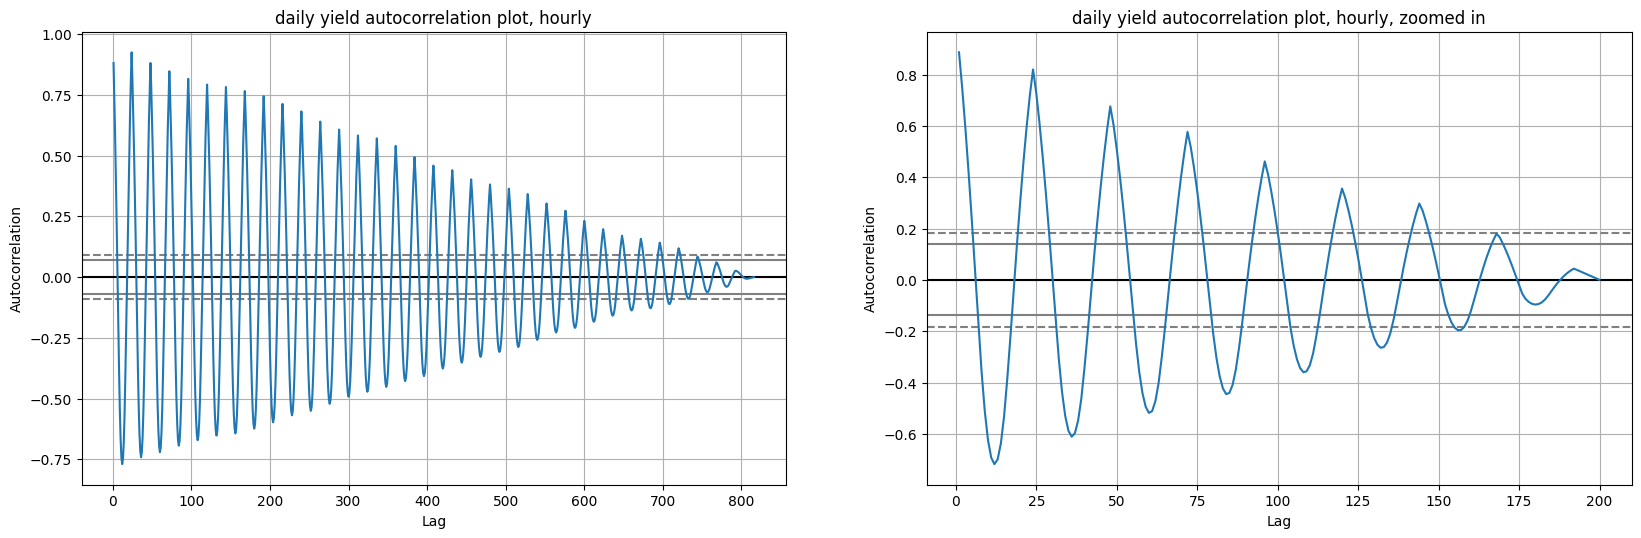

time: 797 ms (started: 2022-03-07 19:44:34 +01:00)


In [1379]:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
autocorrelation_plot(df_plant.groupby(pd.Grouper(freq='1H')).sum()['DAILY_YIELD'], ax = ax[0])
autocorrelation_plot(df_plant.groupby(pd.Grouper(freq='1H')).sum()['DAILY_YIELD'][0:200], ax = ax[1])
ax[0].set_title('daily yield autocorrelation plot, hourly')
ax[1].set_title('daily yield autocorrelation plot, hourly, zoomed in');

If we group the dataframe so that every hour is added up and zoom in, we can see that every 24 hours, the positive correlation is high again, which again makes sense since at this point of time, the sun´s location is almost similar. For the ungrouped dataframe this means that every 24*4=96 time steps, positive correlation is high.

### 2.4.4 Auto Correlation Function

<Figure size 576x576 with 0 Axes>

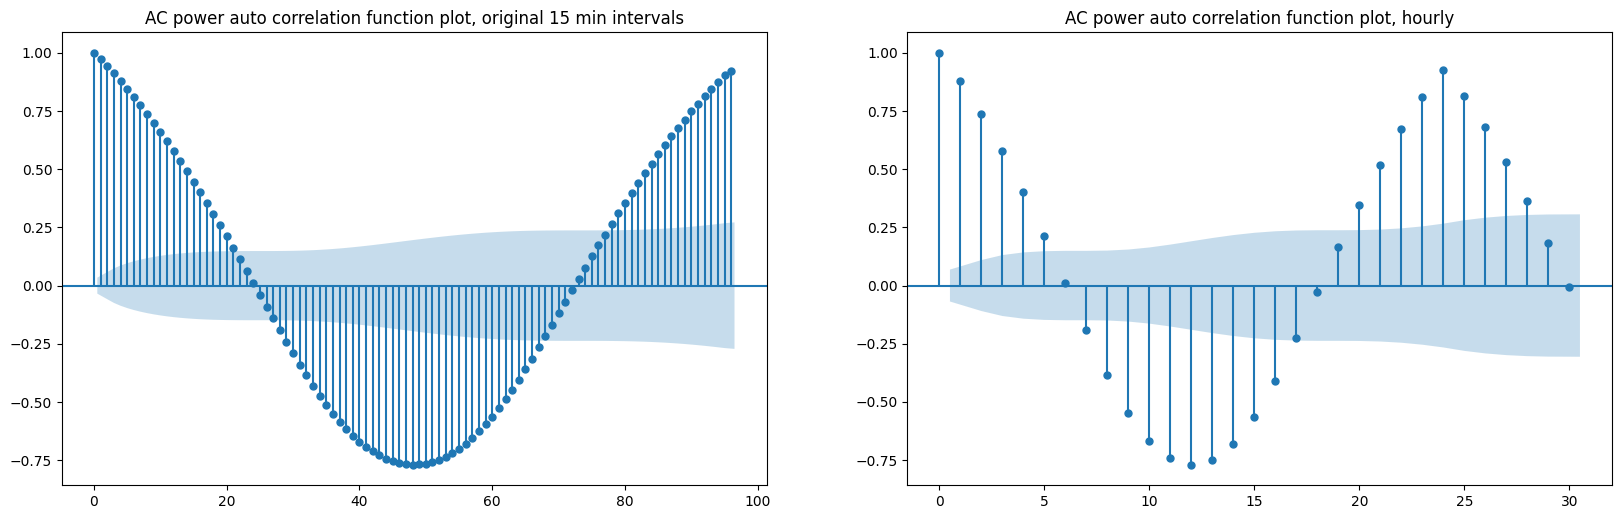

time: 734 ms (started: 2022-03-07 19:39:31 +01:00)


In [1376]:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
plot_acf(df_plant['DAILY_YIELD'], ax = ax[0], lags = 24*4)
plot_acf(df_plant.groupby(pd.Grouper(freq='1H')).sum()['DAILY_YIELD'], ax = ax[1])
ax[0].set_title('daily yield auto correlation function plot, original 15 min intervals')
ax[1].set_title('daily yield auto correlation function plot, hourly');

Here, we learn the same as from the previous 

Text(0.5, 1.0, 'daily yield partial autocorrelation plot, hourly')

<Figure size 576x576 with 0 Axes>

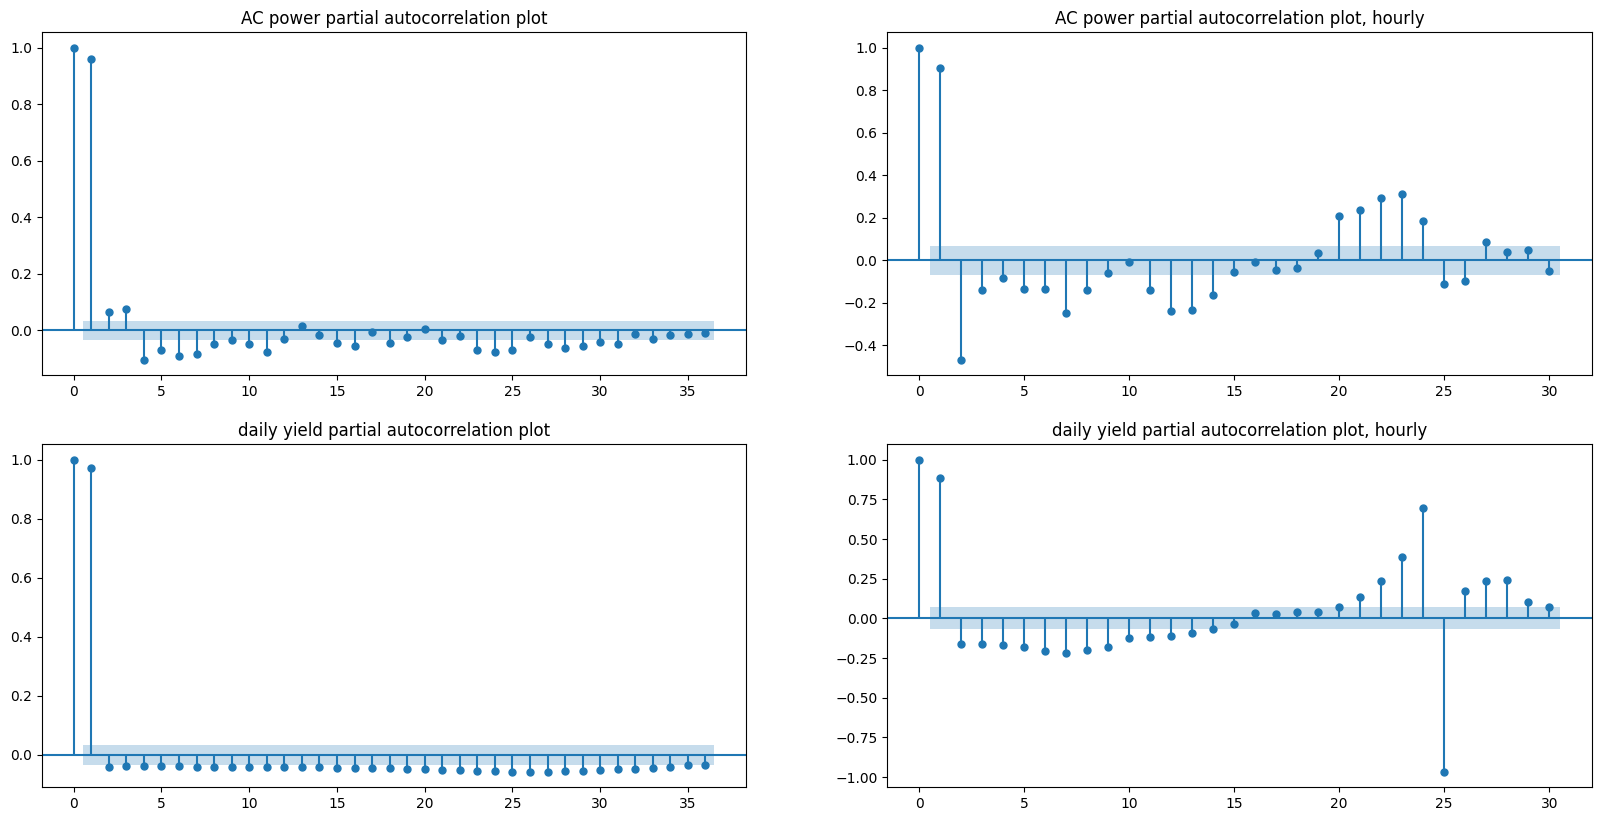

time: 1.09 s (started: 2022-03-07 19:51:07 +01:00)


In [1381]:
plt.figure()
fig,ax = plt.subplots(2,2, dpi=100,figsize=(20,10))
plot_pacf(df_plant['AC_POWER'], ax = ax[0][0])
plot_pacf(df_plant.groupby(pd.Grouper(freq='1H')).sum()['AC_POWER'], ax = ax[0][1])
plot_pacf(df_plant['DAILY_YIELD'], ax = ax[1][0])
plot_pacf(df_plant.groupby(pd.Grouper(freq='1H')).sum()['DAILY_YIELD'], ax = ax[1][1])
ax[0][0].set_title('AC power partial autocorrelation plot')
ax[0][1].set_title('AC power partial autocorrelation plot, hourly')
ax[1][0].set_title('daily yield partial autocorrelation plot')
ax[1][1].set_title('daily yield partial autocorrelation plot, hourly')


We learn that for AC power forcasting, we could possibly use an AR lag of 8 or even 10. However, only the first AR lag shows very high correlation, so the other option would be to use an AR lag of only one.

# 3. Testing Phase I: Baseline models

In [1266]:
# Train-Test Split:
train_start_dt = '2020-05-15 0:00'
test_start_dt = '2020-06-16 0:00'
test_end_dt = '2020-06-17 23:45'
# trainin data: filtered copy
train = df_plant.copy()[(df_plant.index >= train_start_dt) & (df_plant.index < test_start_dt)][['AC_POWER']]
# test data: filtered copy
test = df_plant.copy()[(df_plant.index >= test_start_dt) & (df_plant.index < test_end_dt)][['AC_POWER']]
#let's see how it looks like:
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (2971, 1)
Test data shape:  (287, 1)
time: 0 ns (started: 2022-03-06 23:10:56 +01:00)


rescaling the data:

In [1267]:
featuresToScale = df_plant.columns
# scaler = pp.StandardScaler(copy=True)
scaler = pp.MinMaxScaler()
train['AC_POWER'] = scaler.fit_transform(train)
test['AC_POWER'] = scaler.transform(test)
test.describe()

,AC_POWER
count,287.000000
mean,0.168162
std,0.214616
min,0.000000
25%,0.000000
50%,0.027235
75%,0.339306
max,0.862962


time: 47 ms (started: 2022-03-06 23:10:56 +01:00)


In [1268]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_plant.AC_POWER, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -14.381189153646883
2. P-Value :  9.147133217683669e-27
3. Num Of Lags :  29
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 3229
5. Critical Values :
	 1% :  -3.4323767903784113
	 5% :  -2.862435514116478
	 10% :  -2.5672467017431932
time: 281 ms (started: 2022-03-06 23:10:57 +01:00)


In [1269]:
#-----------------------------------------------------------
#Hyperparameters
#-----------------------------------------------------------
horizon = 6*4
#The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
# d must be an integer indicating the integration order of the process, while p and q may either 
# be an integers indicating the AR and MA orders (so that all lags up to those orders are included)
# or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).
order = (8, 1, 19)
#The (P,D,Q,s) order of the seasonal component of the model for:
# the AR parameters,  differences, MA parameters, and periodicity.
seasonal_order = (1, 1, 1, 96)

time: 0 ns (started: 2022-03-06 23:10:57 +01:00)


In [1270]:
#Model implementation
#here endog is the observed time-series process y:
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)

time: 15 ms (started: 2022-03-06 23:10:58 +01:00)


C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [1271]:
#Copying the test DF:
test_shifted = test.copy()
#preparing the shifted test data:
for t in range(1, horizon):
    test_shifted['AC_POWER+'+str(t)] = test_shifted['AC_POWER'].shift(-t)
test_shifted = test_shifted.dropna()
test_shifted

,AC_POWER,AC_POWER+1,AC_POWER+2,AC_POWER+3,AC_POWER+4,AC_POWER+5,AC_POWER+6,AC_POWER+7,AC_POWER+8,AC_POWER+9,...,AC_POWER+14,AC_POWER+15,AC_POWER+16,AC_POWER+17,AC_POWER+18,AC_POWER+19,AC_POWER+20,AC_POWER+21,AC_POWER+22,AC_POWER+23
2020-06-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-06-15 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.009019
2020-06-15 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.009019,0.026740
2020-06-15 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.009019,0.026740,0.070761
2020-06-15 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009019,0.026740,0.070761,0.101398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 16:45:00,0.154714,0.044214,0.111099,0.112747,0.079780,0.049444,0.026097,0.015782,0.002812,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-06-17 17:00:00,0.044214,0.111099,0.112747,0.079780,0.049444,0.026097,0.015782,0.002812,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-06-17 17:15:00,0.111099,0.112747,0.079780,0.049444,0.026097,0.015782,0.002812,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-06-17 17:30:00,0.112747,0.079780,0.049444,0.026097,0.015782,0.002812,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


time: 125 ms (started: 2022-03-06 23:10:58 +01:00)


In [1272]:
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

time: 0 ns (started: 2022-03-06 23:10:59 +01:00)


In [1273]:
# Predictions on test data:
training_window = 720
train_ts = train['AC_POWER']
test_ts = test_shifted
#Creating the history
history = [x for x in train_ts]
#Filtering the training window: Uncomment the below line if you want.
history = history[(-training_window):]
#Creating predictions to store the model outcomes:
predictions = list()
#Calling model: 
#Horizon calculation list:
for t in range(0,test_ts.shape[0],horizon):
  model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
  #Model fitting:
  model_fit = model.fit()
  #Model predictions:
  y_p = model_fit.forecast(steps = horizon)
  obs = list(test_ts.iloc[t])
# moving the training window: here I add the prediction as in real life we would 
# not know the true value! Here we will also save the predictions.
  for j in range(horizon):
    predictions.append(y_p[j])
    history.append(y_p[j])
  #Dropping the first horizon elements:
  for j in range(horizon):
    history.pop(0)
  print(test_ts.index[t])
  print(t+1, ': predicted =', y_p, '\ntrue value =', obs)

C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2020-06-15 00:00:00
1 : predicted = [-0.00499228 -0.01576274 -0.00481278 -0.01358453 -0.00403374 -0.00943322
 -0.01193843 -0.01229643 -0.01612882 -0.00969494 -0.01443209 -0.01038687
 -0.01464113 -0.01465808 -0.01248353 -0.01553089 -0.01258123 -0.01440961
 -0.01355375 -0.01311539 -0.01424142 -0.01354766 -0.01401466 -0.01397965] 
true value = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2020-06-15 06:00:00
25 : predicted = [-0.00448178  0.01666002  0.04228434  0.07773683  0.13439439  0.17407192
  0.24044097  0.2741027   0.29359987  0.30786316  0.40571047  0.39197979
  0.51107843  0.42718011  0.51364402  0.37331992  0.44359997  0.46150025
  0.42984615  0.41702106  0.47241248  0.50027506  0.50099743  0.44902937] 
true value = [0.009019237080628304, 0.02673978976692319, 0.07076143907206202, 0.10139812681614815, 0.1667837144278534, 0.19579578586197138, 0.18276696233991999, 0.3578241135067413, 0.4104557069315738, 0.47

In [1274]:
# Evaluation of results:
# We will combine the predictions with the actual load values in a DF. 
eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
#Updating the indices:
eval_df=(eval_df.set_index(test.index[0:264])) #
#Adding true values:
eval_df['actual'] = test[0:264]
#Let's check:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2020-06-15 00:00:00 to 2020-06-17 17:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  264 non-null    float64
 1   actual      264 non-null    float64
dtypes: float64(2)
memory usage: 6.2 KB
time: 313 ms (started: 2022-03-07 05:34:04 +01:00)


In [1275]:
#Back-transforming:
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

time: 47 ms (started: 2022-03-07 05:34:05 +01:00)


In [1326]:
eval_df['dy_prediction'] = create_daily_yield_list(eval_df, 'prediction')
eval_df['dy_actual'] = create_daily_yield_list(eval_df, 'actual')
eval_df

,prediction,actual,daily_yield_pred,daily_yield_act,daily_yield_prediction,daily_yield_actual,dy_prediction,dy_actual
2020-06-15 00:00:00,-129.698151,0.000000,-129.698151,-129.698151,-129.698151,0.000000,-129.698151,0.000000
2020-06-15 00:15:00,-409.512308,0.000000,-539.210459,-539.210459,-539.210459,0.000000,-539.210459,0.000000
2020-06-15 00:30:00,-125.034945,0.000000,-664.245405,-664.245405,-664.245405,0.000000,-664.245405,0.000000
2020-06-15 00:45:00,-352.922838,0.000000,-1017.168243,-1017.168243,-1017.168243,0.000000,-1017.168243,0.000000
2020-06-15 01:00:00,-104.795514,0.000000,-1121.963757,-1121.963757,-1121.963757,0.000000,-1121.963757,0.000000
...,...,...,...,...,...,...,...,...
2020-06-17 16:45:00,6122.894237,4019.438572,422687.858738,422687.858738,422687.858738,360953.914286,422687.858738,360953.914286
2020-06-17 17:00:00,5552.722682,1148.673333,428240.581419,428240.581419,428240.581419,362102.587619,428240.581419,362102.587619
2020-06-17 17:15:00,4049.689682,2886.312857,432290.271101,432290.271101,432290.271101,364988.900476,432290.271101,364988.900476
2020-06-17 17:30:00,3077.608609,2929.150000,435367.879711,435367.879711,435367.879711,367918.050476,435367.879711,367918.050476


time: 141 ms (started: 2022-03-07 11:41:25 +01:00)


In [1331]:
eval_df

,prediction,actual,dy_prediction,dy_actual
2020-06-15 00:00:00,-129.698151,0.000000,-129.698151,0.000000
2020-06-15 00:15:00,-409.512308,0.000000,-539.210459,0.000000
2020-06-15 00:30:00,-125.034945,0.000000,-664.245405,0.000000
2020-06-15 00:45:00,-352.922838,0.000000,-1017.168243,0.000000
2020-06-15 01:00:00,-104.795514,0.000000,-1121.963757,0.000000
...,...,...,...,...
2020-06-17 16:45:00,6122.894237,4019.438572,422687.858738,360953.914286
2020-06-17 17:00:00,5552.722682,1148.673333,428240.581419,362102.587619
2020-06-17 17:15:00,4049.689682,2886.312857,432290.271101,364988.900476
2020-06-17 17:30:00,3077.608609,2929.150000,435367.879711,367918.050476


time: 16 ms (started: 2022-03-07 11:44:30 +01:00)


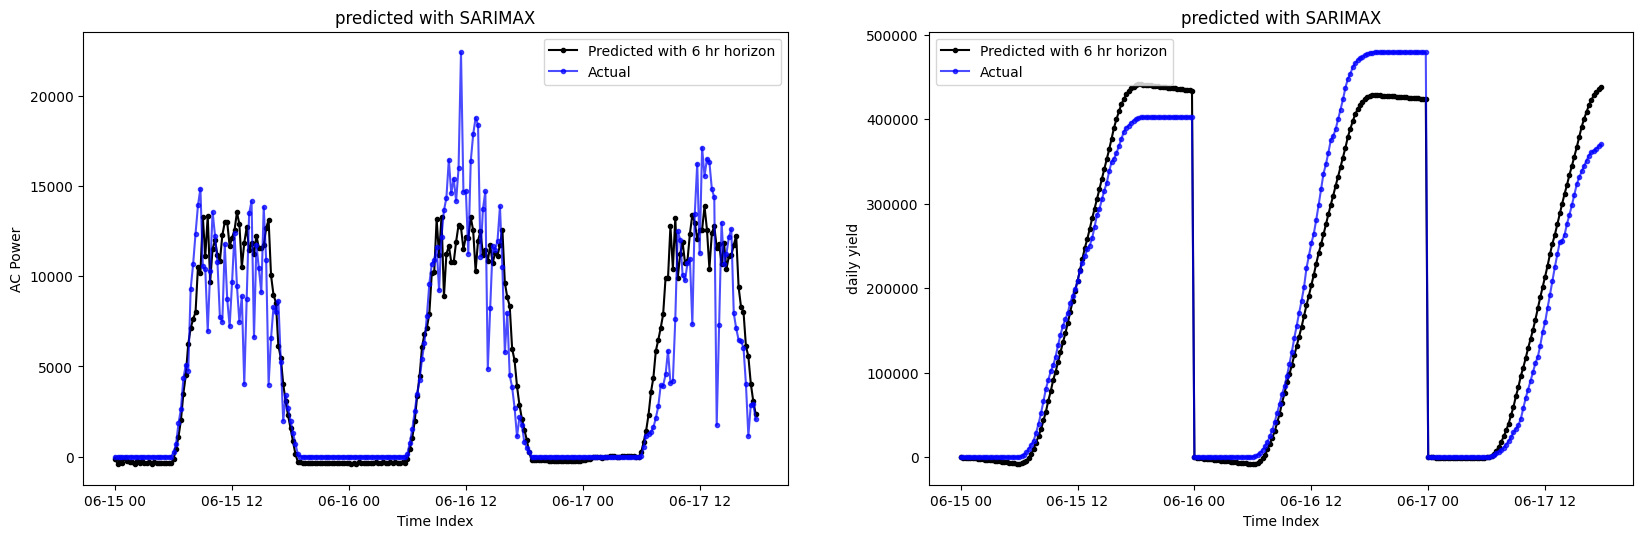

time: 735 ms (started: 2022-03-07 12:11:37 +01:00)


In [1352]:
#Plotting predictions vs actual values: 
def plot_pred_vs_actual(title):
    fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
    for i in range(0,2):
        ax[i].plot(eval_df.iloc[:,i*2], 'k.-')
        ax[i].plot(eval_df.iloc[:,1+i*2], 'b.-', alpha=0.70)
        ax[i].legend([f'Predicted with {int(horizon/4)} hr horizon', 'Actual'])
        ax[i].set_title(f"predicted with {title}")
        ax[i].set_xlabel('Time Index')
    ax[0].set_ylabel('AC Power')
    ax[1].set_ylabel('daily yield')

plot_pred_vs_actual('SARIMAX')

In [1364]:
min(eval_df.iloc[:,0].min(),eval_df.iloc[:,2].min())
eval_df

,prediction,actual,dy_prediction,dy_actual
2020-06-15 00:00:00,-129.698151,0.000000,-129.698151,0.000000
2020-06-15 00:15:00,-409.512308,0.000000,-539.210459,0.000000
2020-06-15 00:30:00,-125.034945,0.000000,-664.245405,0.000000
2020-06-15 00:45:00,-352.922838,0.000000,-1017.168243,0.000000
2020-06-15 01:00:00,-104.795514,0.000000,-1121.963757,0.000000
...,...,...,...,...
2020-06-17 16:45:00,6122.894237,4019.438572,422687.858738,360953.914286
2020-06-17 17:00:00,5552.722682,1148.673333,428240.581419,362102.587619
2020-06-17 17:15:00,4049.689682,2886.312857,432290.271101,364988.900476
2020-06-17 17:30:00,3077.608609,2929.150000,435367.879711,367918.050476


time: 31 ms (started: 2022-03-07 12:20:59 +01:00)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

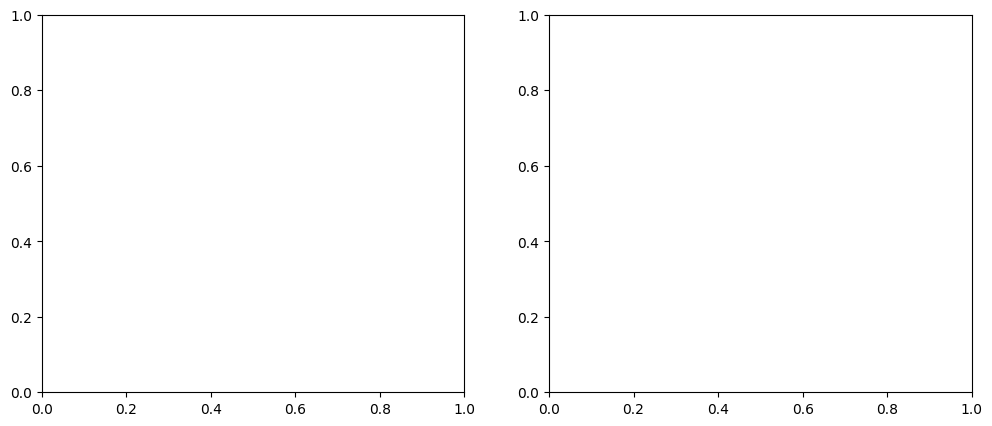

time: 437 ms (started: 2022-03-07 12:21:33 +01:00)


In [1365]:
#Visual comparisons of the predictions:
#---------------------------------------
#Visualization of the accuracy
def plot_accuracy(title):
    fig, ax = plt.subplots(1,2, dpi=100,figsize=(12,5))
    for i, var in enumerate(["AC Power", "daily yield"]):
        lims = [min(eval_df.iloc[:,2*i].min(), eval_df.iloc[:2*i+1].min()), max([eval_df.iloc[:,2*i].max(), eval_df.iloc[:2*i+1].max()])]
        ax[i].plot(lims, lims)
        ax[i].scatter(eval_df.iloc[:,1+i*2], eval_df.iloc[:,i*2], marker='o',alpha=0.8)
        ax[i].set_title(f"predicted with {title}")
        ax[i].set_xlabel(f'True {var}')
        ax[i].set_ylabel(f'predicted {var}')

plot_accuracy('SARIMAX')

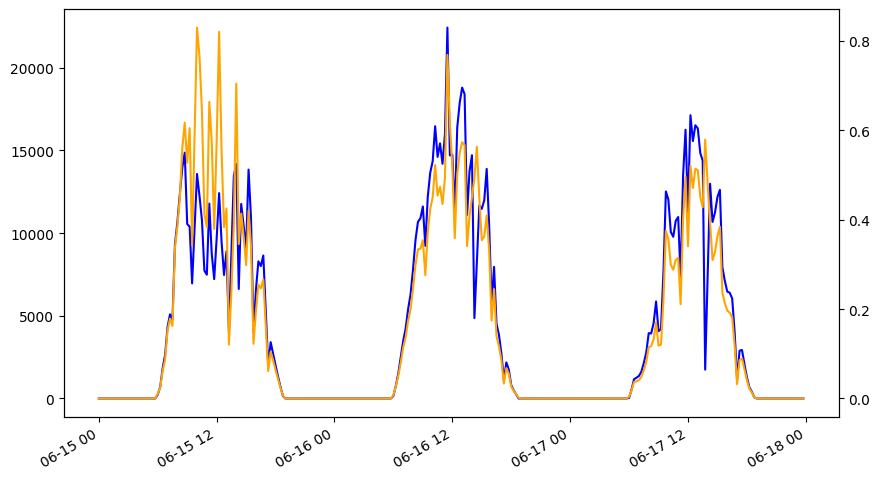

time: 484 ms (started: 2022-03-07 08:51:43 +01:00)


In [1289]:
fig, ax = plt.subplots(1,1, dpi=100,figsize=(10,6))
fig.autofmt_xdate()
ax.plot(df_plant[test_start_dt:test_end_dt].index, df_plant[test_start_dt:test_end_dt]['AC_POWER'], c = 'blue')
ax2=ax.twinx()
ax2.plot(df_plant[test_start_dt:test_end_dt].index, df_plant[test_start_dt:test_end_dt]['IRRADIATION'], c = 'orange')